### 0.0 Introduction

#### This notebook uses data scraped from kickstarter by webrobots (found here : https://webrobots.io/kickstarter-datasets/). Performs an exploratory clustering analysis on these data. It uses word2vec to transform the text data in this set into a 7 dimensional vector.

In [1]:
import requests
import random
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import scipy

### 1.0 Importing Data and Selecting Features.

In [2]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [3]:
pd.set_option('display.max_columns', 1000)

In [4]:
month_folders = ['April2023', 'August2023', 'February2023', 'January2022',
                 'January2023', 'July2023', 'June2023', 'March2023', 'May2023', 'September2023'];

In [5]:
raw_df = pd.DataFrame();

current_paths = [];
for month in month_folders:
    current_paths = current_paths + [join(month, x) for x in listdir(month) if '.csv' in x]

for current_path in current_paths:
    df_temp = pd.read_csv(current_path);
    raw_df = pd.concat([raw_df, df_temp])

raw_df = raw_df.reset_index(drop = True)

In [6]:
raw_df.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,location,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,friends,is_backing,is_starred,permissions
0,230,I know how difficult it is to gain any experie...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",11211.0,GB,the United Kingdom,1389127645,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,£,False,USD,1393111179,False,1.238278,1999.0,542567707,False,1390519179,"{""id"":44418,""name"":""London"",""slug"":""london-gb""...",Cisco CCNA and CCNA Security for the Real Worl...,"{""key"":""assets/011/631/975/49f72198be90d30752b...",6746.0,"{""id"":839405,""project_id"":839405,""state"":""inac...",cisco-ccna-and-ccna-security-for-the-real-worl...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1393111180,1.648362,"{""web"":{""project"":""https://www.kickstarter.com...",1.661914,11119.847421,international,NaN,NaN,NaN,NaN


In [7]:
df_selected = raw_df[['backers_count', 'blurb',
                      'category', 'country', 'creator',
                      'currency', 'currency_trailing_code',
                      'disable_communication', 'fx_rate',
                      'goal', 'is_starrable', 'name',
                      'pledged', 'slug', 'spotlight',
                      'staff_pick', 'state', 'usd_exchange_rate',
                      'usd_pledged']]

In [8]:
df_selected.loc[:,'category'] = (df_selected.copy()).apply(lambda x : ast.literal_eval(x['category'])['name'], axis = 1)

In [9]:
df_selected.head(1)

,backers_count,blurb,category,country,creator,currency,currency_trailing_code,disable_communication,fx_rate,goal,is_starrable,name,pledged,slug,spotlight,staff_pick,state,usd_exchange_rate,usd_pledged
0,230,I know how difficult it is to gain any experie...,Software,GB,"{""id"":1818855509,""name"":""Marious"",""is_register...",GBP,False,False,1.238278,1999.0,False,Cisco CCNA and CCNA Security for the Real Worl...,6746.0,cisco-ccna-and-ccna-security-for-the-real-worl...,True,False,successful,1.661914,11119.847421


### 2.0 Word Embedding

##### I am going to create a corpus from the, "name," "slug," and "blub" text fields. Concatenating thiese strings together for each entry will make a sentence for each data point which I will then append into a list that will represent my word corpus.

In [10]:
corpus = [];
corpus_index = []

for index, row in df_selected.iterrows():
    try:
        sentence = [row['name'] + '. ' + row['slug'] + '. ' + row['blurb']];
        corpus = corpus + sentence;
        corpus_index.append(index);
    
    except:
        continue;

##### I am going to keep a record of each sentence and the corresponding data index in a data frame calld df_corpus.

In [11]:
df_corpus = pd.DataFrame({'sentences' : corpus}, index = corpus_index)

##### Now I will use simple_preprocess from gensim.utils to cast the corpus in to a standard format that word2vec can use and then train the model.

In [12]:
corpus_preprocessed = [simple_preprocess(i) for i in corpus]

In [13]:
model = Word2Vec(corpus_preprocessed, min_count = 1, vector_size = 7)

##### Now that the model is trained I will make lookup table called df_high_dimensional_vocab that will keep a record of each 7 dimensional vector, represented by the columns [t, u, v, w, x, y, z], and the word that it corresponds to. 

In [14]:
vocabulary = []
for index, word in enumerate(model.wv.index_to_key):
    vocabulary = vocabulary + [{'t' : list(model.wv[word])[0],
                                'u' : list(model.wv[word])[1],
                                'v' : list(model.wv[word])[2], 
                                'w' : list(model.wv[word])[3], 
                                'x' : list(model.wv[word])[4],
                                'y' : list(model.wv[word])[5],
                                'z' : list(model.wv[word])[6],
                                'word' : word}]

In [15]:
df_high_dimension_vocab = pd.DataFrame(vocabulary).set_index('word', drop = True)

#### 2.1 Plotting a PCA-reduced version of the data

##### As a small sanity check I am going to reduce the dimension of the corpus-vector space using PCA and plot the distribution of points.

In [16]:
wv_reduced = PCA(n_components = 2)
wv_reduced.fit(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])
reduced_vocab_vectors = wv_reduced.transform(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])

In [17]:
df_reduced_vocab = pd.DataFrame({'x': list(reduced_vocab_vectors[:, 0]), 
                                 'y': list(reduced_vocab_vectors[:, 1]),
                                 'word' : df_high_dimension_vocab.index})

<Axes: xlabel='x', ylabel='y'>

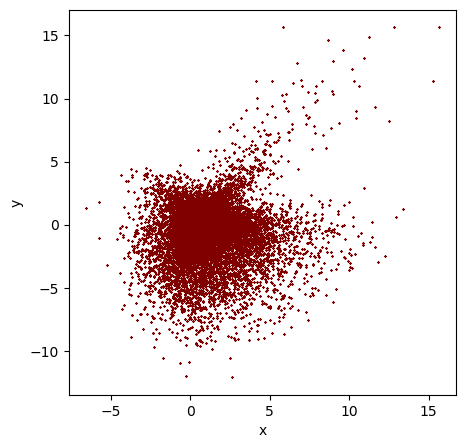

In [18]:
df_reduced_vocab.plot.scatter(x = 'x', y = 'y', s = 1, marker = 'x', figsize = (5, 5), color = [[0.5, 0.0, 0.0]])

##### It definitly looks like there is some complex structure in higher dimensions, which is good.

### 3.0 Clustering

In [19]:
df_w_sentences = pd.concat([df_selected[['backers_count',
                                         'category',
                                         'fx_rate',
                                         'goal',
                                         'pledged',
                                         'state']].loc[df_corpus.index],df_corpus], axis = 1)

In [20]:
df_w_sentences[['t', 'u', 'v', 'w', 'x', 'y', 'z']] = np.nan

In [21]:
df_w_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z
0,230,Software,1.238278,1999.0,6746.0,successful,Cisco CCNA and CCNA Security for the Real Worl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34,Software,1.238278,200.0,1079.0,successful,Strong File Encryption Tool. strong-file-encry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def sentence_median(sentence_string):
    processed_sentence = simple_preprocess(sentence_string);
    sentence_list = [];
    sentence_median = 7*[np.nan];
    for word in processed_sentence:
        try:      
            sentence_list.append(df_high_dimension_vocab.loc[word])
        except:
            break;
            
    sentence_array = np.array(sentence_list)
    return np.median(sentence_array, axis = 0)

In [23]:
error_index = []
for index, row in df_w_sentences.iterrows():
    try:
        df_w_sentences.loc[index, ['t', 'u', 'v', 'w', 'x', 'y', 'z']] = sentence_median(row['sentences'])
    except:
        error_index.append(index)

/home/jason/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jason/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
df_w_sentences.head(2)

,backers_count,category,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z
0,230,Software,1.238278,1999.0,6746.0,successful,Cisco CCNA and CCNA Security for the Real Worl...,-0.191858,-0.669758,1.163831,2.608694,0.608838,-3.573853,-0.428943
1,34,Software,1.238278,200.0,1079.0,successful,Strong File Encryption Tool. strong-file-encry...,1.158347,-0.805251,-0.175260,3.812599,1.324710,-0.583737,0.498378


In [25]:
df_w_sentences['goal_usd'] = df_w_sentences['goal'] * df_w_sentences['fx_rate']

In [26]:
df_w_sentences['pledged_usd'] = df_w_sentences['pledged'] * df_w_sentences['fx_rate']

In [27]:
df_w_sentences.to_csv('./usd_converted_data_with_sentences.csv', index = False);

In [28]:
df_cluster = df_w_sentences[['category', 'state','backers_count', 'goal_usd', 'pledged_usd', 'sentences', 't', 'u', 'v', 'w', 'x', 'y', 'z']]

In [29]:
def map_state_to_number(state_string):
    lookup = {"failed": -3.0,
              "canceled": -2.0,
              "suspended" : -1.0,
              "submitted" : 0.0,
              "started" : 1.0,
              "live" : 2.0,
              "successful" : 3.0};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [30]:
category_lookup = {}
for index, item in enumerate(list(set(df_w_sentences['category']))):
    category_lookup.update({item: index})

In [31]:
def map_category_to_number(state_string, category_lookup):
    try:
        value = category_lookup[state_string];
    except:
        value = -1.1;
    
    return value

In [32]:
df_cluster_copy = df_cluster.copy()

In [33]:
df_cluster_copy.columns

Index(['category', 'state', 'backers_count', 'goal_usd', 'pledged_usd',
       'sentences', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='object')

In [34]:
df_cluster_copy['state'] = df_cluster['state'].apply(lambda x : map_state_to_number(x))

In [35]:
df_cluster_copy['category'] = df_cluster['category'].apply(lambda x : map_category_to_number(x, category_lookup))

array([[<Axes: title={'center': 'state'}>]], dtype=object)

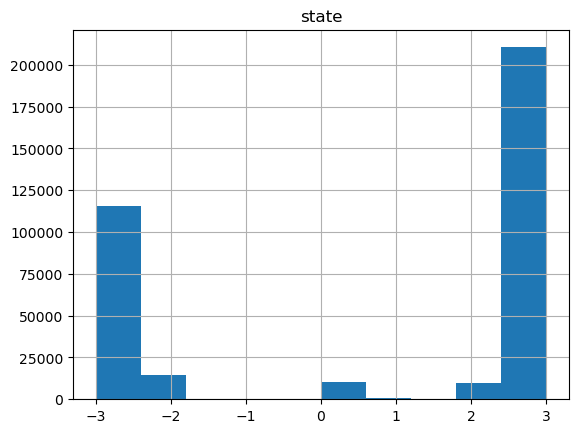

In [36]:
df_cluster_copy.hist(column = 'state', grid = True)

array([[<Axes: title={'center': 'category'}>]], dtype=object)

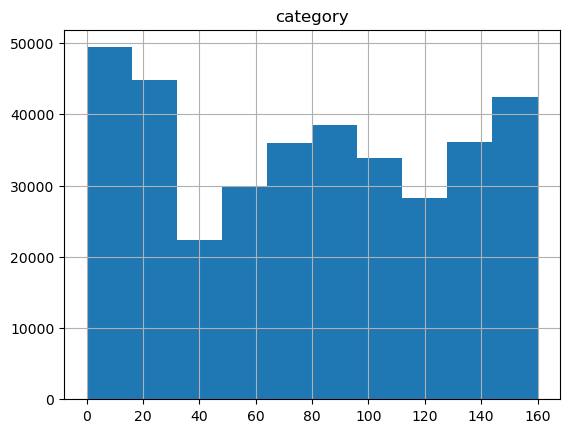

In [37]:
df_cluster_copy.hist(column = 'category', grid = True)

In [38]:
df_cluster_copy.to_csv("./kickstarter_numerical_clustering_dataset.csv", index = False)

In [39]:
df_cluster_copy.head()

,category,state,backers_count,goal_usd,pledged_usd,sentences,t,u,v,w,x,y,z
0,12,3.0,230,2475.318022,8353.424400,Cisco CCNA and CCNA Security for the Real Worl...,-0.191858,-0.669758,1.163831,2.608694,0.608838,-3.573853,-0.428943
1,12,3.0,34,247.655630,1336.102124,Strong File Encryption Tool. strong-file-encry...,1.158347,-0.805251,-0.175260,3.812599,1.324710,-0.583737,0.498378
2,12,3.0,226,10000.000000,17451.000000,YaCyPi - Turnkey Raspberry Pi based Internet S...,0.273465,-1.423879,-0.628152,3.566036,0.795674,-2.504683,0.283239
3,12,3.0,655,50000.000000,51309.830000,"Everydisk – Easily access all your computers, ...",-0.948226,-1.527217,0.806895,4.830170,1.725382,-3.123185,-1.239912
4,12,3.0,24,123.772180,301.385258,Traccar Client for iOS. traccar-client-for-ios...,1.662931,0.322072,-2.238781,5.242403,2.084165,-1.346829,-0.603822


In [40]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [41]:
df_cluster_with_sentences = pd.read_csv('./kickstarter_numerical_clustering_dataset.csv')

In [42]:
df_cluster = df_cluster_with_sentences.copy().drop(['sentences'], axis = 1);

In [43]:
df_cluster = df_cluster.dropna(axis = 0)

In [44]:
def silhouette_plot(silhouette_values, silhouette_average, labels):
    
    fig, ax = plt.subplots();
    fig.set_size_inches(6,6);
    
    ax.set_xlim([-0.1, 1.0]);
    ax.set_ylim([0, len(silhouette_values) + (len(set(labels)) + 1) * 10])
    
    cluster_plot_lower_y_value = 10;
    for label_value in list(set(labels)):
        label_n_silhouette_values = sorted([silhouette_values[i] for i in range(len(labels)) if labels[i] == label_value]);
        
        size_of_n_cluster = len(label_n_silhouette_values);
        cluster_plot_upper_y_value = cluster_plot_lower_y_value + size_of_n_cluster
        
        color = cm.nipy_spectral(float(label_value/len(set(labels))));
        plt.fill_betweenx(np.arange(cluster_plot_lower_y_value, cluster_plot_upper_y_value),
                          0,
                          label_n_silhouette_values,
                          facecolor = color,
                          edgecolor = color,
                          alpha = 0.7)
        
        ax.text(-0.05, cluster_plot_lower_y_value + 0.5*size_of_n_cluster, str(label_value));        
        cluster_plot_lower_y_value = cluster_plot_upper_y_value + 10;              
        
    ax.axvline(x=silhouette_average, color = "red", linestyle = "--");

    ax.set_yticks([]);
    ax.set_xticks([-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]);

    ax.set_ylabel("cluster assignment", rotation = 45, horizontalalignment = 'right')
    ax.set_xlabel("silhouette score");
    ax.set_title("silhoutte plot for {} clusters".format(len(set(labels))));
                                                    
    return fig, ax    

In [45]:
def scale_data(df_in):
    
    scaler = StandardScaler();
    
    transformed_data = scaler.fit_transform(df_in.values)
    df_transformed = pd.DataFrame(columns = df_in.columns,
                                  data = transformed_data,
                                  index = df_in.index);
    
    return df_transformed;

In [46]:
def k_means_processing(df_in, n_clusters):
    
    kmeans = KMeans(n_clusters = n_clusters, n_init = 50)
    
    model = kmeans.fit(df_in);
    cluster_labels = model.predict(df_in);
    
    silhouette_average = silhouette_score(df_in, cluster_labels);
    silhouette_values = list(silhouette_samples(df_in, cluster_labels).flatten());
    
    df_in.loc[:,'labels_' + str(n_clusters) + '_clusters'] = cluster_labels;
    
    return df_in, model, cluster_labels, silhouette_values, silhouette_average

#### 3.1 K-means Fitting

In [ ]:
data_dict = {}
number_clusters_to_try = [6]
df_cluster_scaled = scale_data(df_cluster)
for number_clusters in number_clusters_to_try:
    df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, number_clusters)
    
    data_dict.update({number_clusters : df_cluster_labeled})
    
    joblib.dump(data_dict, './clustering_results.pickle')
    
    silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

In [48]:
# data_dict = {}
# df_cluster_scaled = scale_data(df_cluster)

# df_cluster_labeled, kmeans_model, cluster_labels, silhouette_values, silhouette_average = k_means_processing(df_cluster_scaled, 6)

# data_dict.update({6 : df_cluster_labeled})
    
# joblib.dump(data_dict, './clustering_results.pickle')
    
# silhouette_plot(silhouette_values, silhouette_average, cluster_labels)

In [48]:
df_6_clusters = df_cluster;

In [49]:
df_6_clusters.loc[:, 'labels_6_clusters'] = df_cluster_labeled['labels_6_clusters']

In [50]:
df_6_clusters.to_csv('./labled_cluster_data_with_6_clusters.csv', index = False)

In [51]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,t,u,v,w,x,y,z,labels_6_clusters
0,44,3.0,230,2475.318022,8353.424400,0.310695,-0.396151,1.546743,3.356549,0.344880,-3.312825,-0.715169,3
1,44,3.0,34,247.655630,1336.102124,0.883690,-0.864662,-0.804044,4.203511,0.644622,-1.558952,0.617319,3
2,44,3.0,226,10000.000000,17451.000000,-0.080172,-1.928618,-0.952074,3.678897,0.328286,-2.904679,0.198415,3
3,44,3.0,655,50000.000000,51309.830000,-0.782412,-2.278030,1.181654,5.510535,0.828395,-2.921547,-0.925204,3
4,44,3.0,24,123.772180,301.385258,0.206875,-2.010103,-3.194418,4.421043,1.658966,-2.199790,0.700953,3


#### 3.1 Median Words

##### I am going to use the word vector features to assign the word that corresponds to the 7 dimensional embedding vector for each data point AND then also assign the word that corresponds to the median vector for all of the data points in each cluster.

In [52]:
df_6_clusters.loc[:, 'median_data_point_word'] = df_6_clusters.apply(lambda x : model.wv.most_similar(x[['t', 'u', 'v', 'w', 'x', 'y', 'z']].values, topn = 1), axis = 1)

In [53]:
df_6_clusters.loc[:, 'median_data_point_word'] = df_6_clusters['median_data_point_word'].apply(lambda x : x[0][0])

In [54]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,t,u,v,w,x,y,z,labels_6_clusters,median_data_point_word
0,44,3.0,230,2475.318022,8353.424400,0.310695,-0.396151,1.546743,3.356549,0.344880,-3.312825,-0.715169,3,pleasure
1,44,3.0,34,247.655630,1336.102124,0.883690,-0.864662,-0.804044,4.203511,0.644622,-1.558952,0.617319,3,dibujitos
2,44,3.0,226,10000.000000,17451.000000,-0.080172,-1.928618,-0.952074,3.678897,0.328286,-2.904679,0.198415,3,unprecedented
3,44,3.0,655,50000.000000,51309.830000,-0.782412,-2.278030,1.181654,5.510535,0.828395,-2.921547,-0.925204,3,xoss
4,44,3.0,24,123.772180,301.385258,0.206875,-2.010103,-3.194418,4.421043,1.658966,-2.199790,0.700953,3,terrorisme


In [55]:
def median_cluster_word(df_in, label_column_name):
    clusters = sorted(set(df_in[label_column_name]));
    median_value = {};
    for cluster_number in clusters:
        median_value.update({cluster_number : {'vector' : df_in.loc[df_in[label_column_name] == cluster_number,['t', 'u', 'v', 'w', 'x', 'y', 'z']].median().values,
                                              'word' : np.nan}});
    
    for cluster_number in median_value:
        median_value[cluster_number]['word'] = model.wv.most_similar(positive = median_value[cluster_number]['vector'], topn = 1)[0][0];
        
    return median_value;

In [56]:
median_cluster_words = median_cluster_word(df_6_clusters, 'labels_6_clusters')

In [57]:
df_6_clusters['median_cluster_word'] = ""

In [58]:
for key in median_cluster_words:
    df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == key, 'median_cluster_word'] = median_cluster_words[key]['word']

In [59]:
df_6_clusters.loc[df_6_clusters['labels_6_clusters'] == 3, 'median_cluster_word'] = median_cluster_words[3]['word']

In [60]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,t,u,v,w,x,y,z,labels_6_clusters,median_data_point_word,median_cluster_word
0,44,3.0,230,2475.318022,8353.424400,0.310695,-0.396151,1.546743,3.356549,0.344880,-3.312825,-0.715169,3,pleasure,líquido
1,44,3.0,34,247.655630,1336.102124,0.883690,-0.864662,-0.804044,4.203511,0.644622,-1.558952,0.617319,3,dibujitos,líquido
2,44,3.0,226,10000.000000,17451.000000,-0.080172,-1.928618,-0.952074,3.678897,0.328286,-2.904679,0.198415,3,unprecedented,líquido
3,44,3.0,655,50000.000000,51309.830000,-0.782412,-2.278030,1.181654,5.510535,0.828395,-2.921547,-0.925204,3,xoss,líquido
4,44,3.0,24,123.772180,301.385258,0.206875,-2.010103,-3.194418,4.421043,1.658966,-2.199790,0.700953,3,terrorisme,líquido


#### 3.3 Translating numbers back to strings

##### Now that the vectors have been translated back into words I am going to remove the [t, u, v, w, x, y, z] embedding features.

In [61]:
df_6_clusters.drop(['t', 'u', 'v', 'w', 'x', 'y', 'z'], axis = 1, inplace = True)

In [62]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,44,3.0,230,2475.318022,8353.424400,3,pleasure,líquido
1,44,3.0,34,247.655630,1336.102124,3,dibujitos,líquido
2,44,3.0,226,10000.000000,17451.000000,3,unprecedented,líquido
3,44,3.0,655,50000.000000,51309.830000,3,xoss,líquido
4,44,3.0,24,123.772180,301.385258,3,terrorisme,líquido


##### I will also translate the category and state numbers back into their string values

In [63]:
def map_number_to_state(state_string):
    lookup = {-3.0 : "failed",
              -2.0 : "canceled",
              -1.0 : "suspended",
               0.0 : "submitted",
               1.0 : "started", 
               2.0 : "live",
               3.0 : "successful"};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [64]:
reverse_category_lookup = {}
for index, item in enumerate(list(set(df_w_sentences['category']))):
    reverse_category_lookup.update({index: item})

In [65]:
def map_number_to_category(state_number, reverse_category_lookup):
    try:
        value = reverse_category_lookup[state_number];
    except:
        value = 'missing'
    
    return value

In [66]:
df_6_clusters.loc[:, 'state'] = df_6_clusters['state'].apply(lambda x : map_number_to_state(x));

In [67]:
df_6_clusters.loc[:, 'category'] = df_6_clusters['category'].apply(lambda x : map_number_to_category(x, reverse_category_lookup))

In [68]:
df_6_clusters.head()

,category,state,backers_count,goal_usd,pledged_usd,labels_6_clusters,median_data_point_word,median_cluster_word
0,Software,successful,230,2475.318022,8353.424400,3,pleasure,líquido
1,Software,successful,34,247.655630,1336.102124,3,dibujitos,líquido
2,Software,successful,226,10000.000000,17451.000000,3,unprecedented,líquido
3,Software,successful,655,50000.000000,51309.830000,3,xoss,líquido
4,Software,successful,24,123.772180,301.385258,3,terrorisme,líquido


In [69]:
df_6_clusters.to_csv('./analysis_ready_6_cluster_data.csv', index = False)

### 4.0 Analysis

#### 4.1 Exploration

##### Now the data are partitioned (with the clustering algorithm) and the langage data has been incorporated into that partitioning in a ration way, I will reimport the data under a different variable name and complete the exploratory analysis.

In [70]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

In [71]:
df_analysis = pd.read_csv('./analysis_ready_6_cluster_data.csv')

In [88]:
# Here I define a simple function to calculate the mode of an array.

def custom_mode(data):
    count_dict = {}
    for value in set(data):
        count_dict.update({value : 0.0})
        
    for value in data:
        count_dict[value] += 1;
        
    count_dict = sorted(count_dict.items(), key = lambda x : x[1], reverse = True)
    
    return count_dict[0][0]

In [89]:
# Here I define a function that allows me to round to the nearest order of magnitude (power): i.e. 1230 -> 1200 for power of two

def custom_round(data, power):
    rounded_value = 0.0;
    data_copy = data.copy();
    for index, value in enumerate(data):
         data_copy[index] = round(value/(10**power))*(10**power);
            
    return data_copy;      

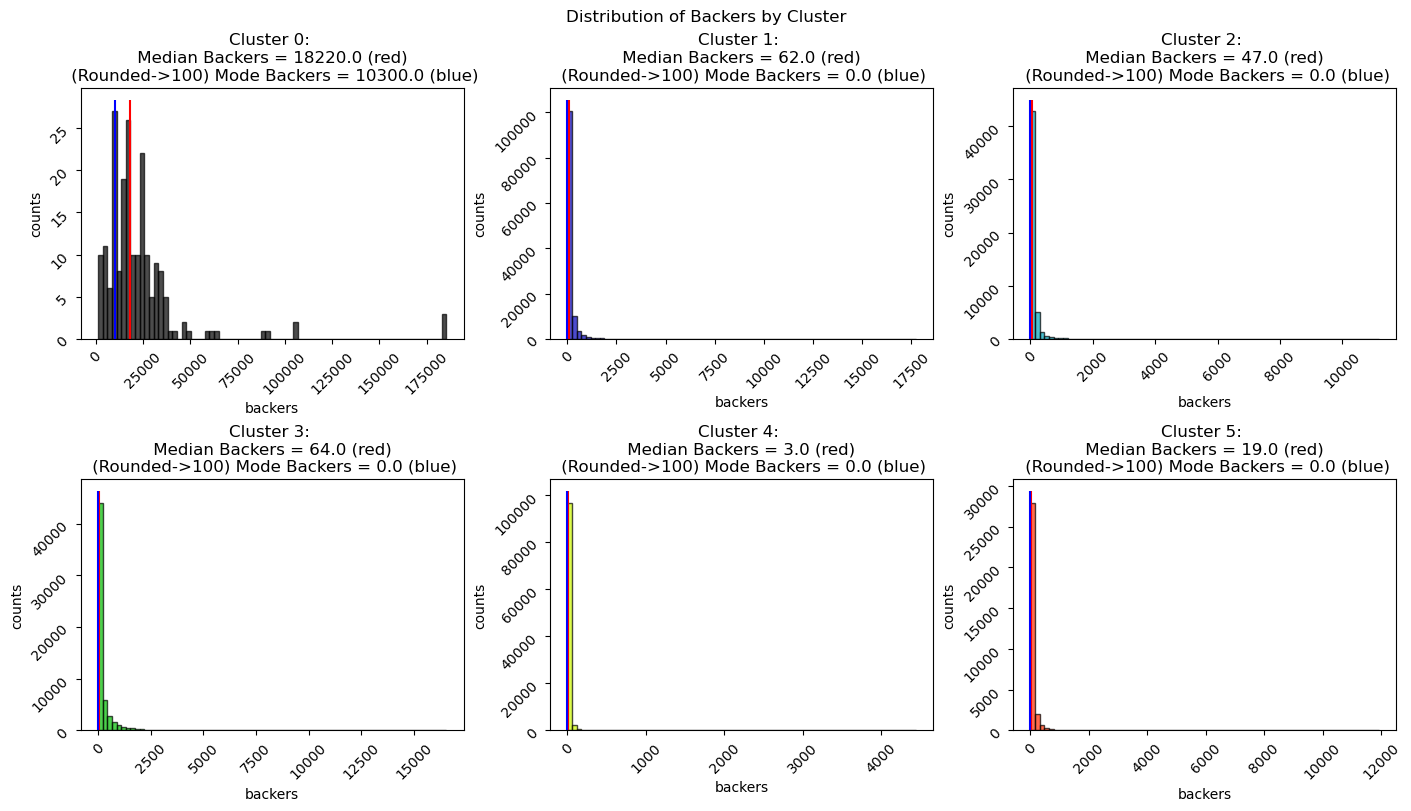

In [90]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Backers by Cluster")

backer_x_lims = [750, 4000, 250, 80, 1000, 1000]
backer_y_lims = [6e3, 1.25e4, 1e4, 4.5e4, 1.5e4, 7e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_analysis.loc[df_analysis['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[:, 'backers_count'].values;
    median = np.median(hist_data)
    mode = custom_mode(custom_round(hist_data, 2));
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}: \n Median Backers = {:.1f} (red) \n (Rounded->100) Mode Backers = {:.1f} (blue)'.format(index, median, mode))
    ax.set_xlabel('backers')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)
    ylims = ax.get_ylim();
    ax.vlines(median, ylims[0], ylims[1], colors = 'r')
    ax.vlines(mode, ylims[0], ylims[1], colors = 'b')

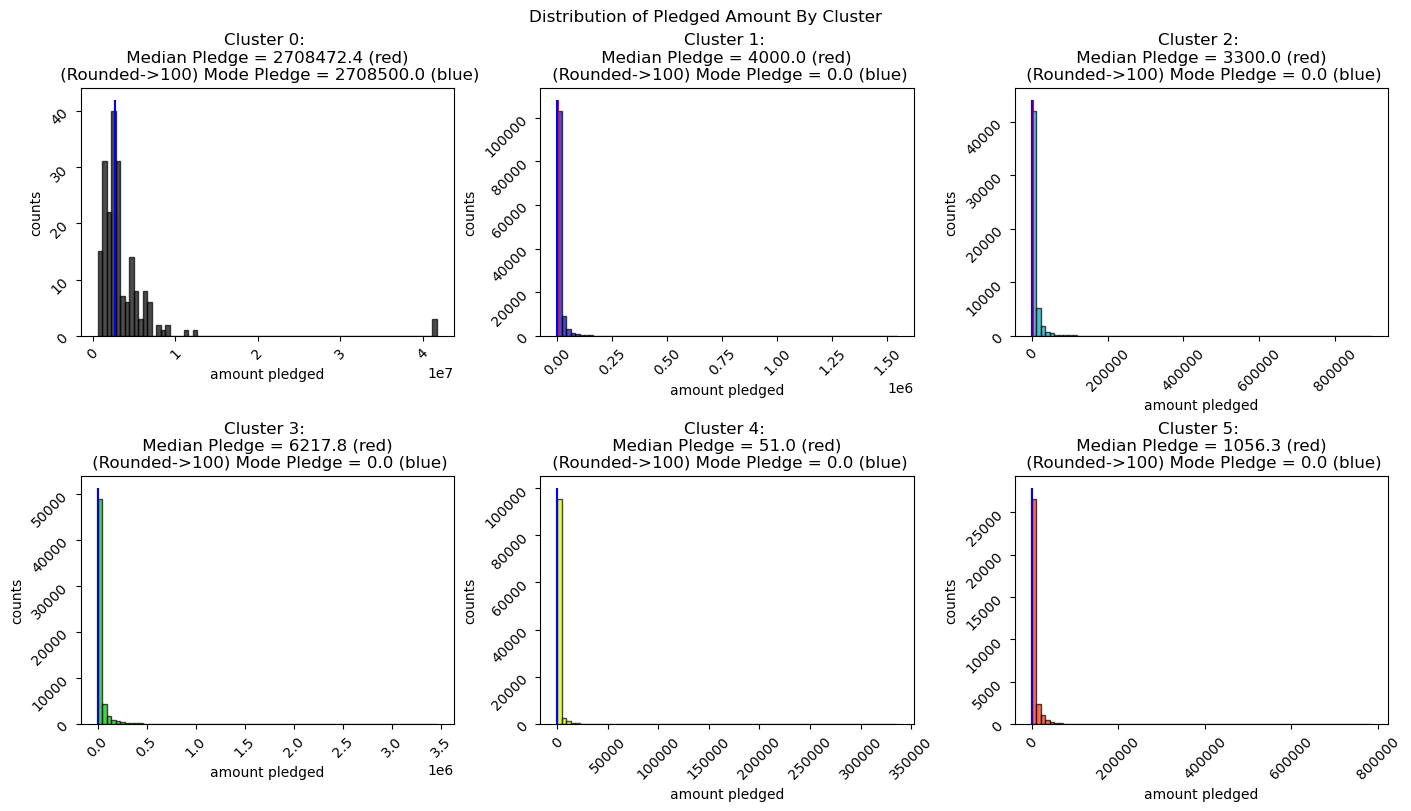

In [91]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Pledged Amount By Cluster")

pledged_x_lims = [5e4, 4e4, 3e4, 2e3, 3e4, 4e4]
pledged_y_lims = [1.25e4, 6e3, 1.5e4, 5e4, 1e4, 5e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_analysis.loc[df_analysis['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[:, 'pledged_usd'].values
    median = np.median(hist_data)
    mode = custom_mode(custom_round(hist_data, 2));
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}: \n Median Pledge = {:.1f} (red) \n (Rounded->100) Mode Pledge = {:.1f} (blue)'.format(index, median, mode))
    ax.set_xlabel('amount pledged')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)
    ylims = ax.get_ylim();
    ax.vlines(median, ylims[0], ylims[1], colors = 'r')
    ax.vlines(mode, ylims[0], ylims[1], colors = 'b')

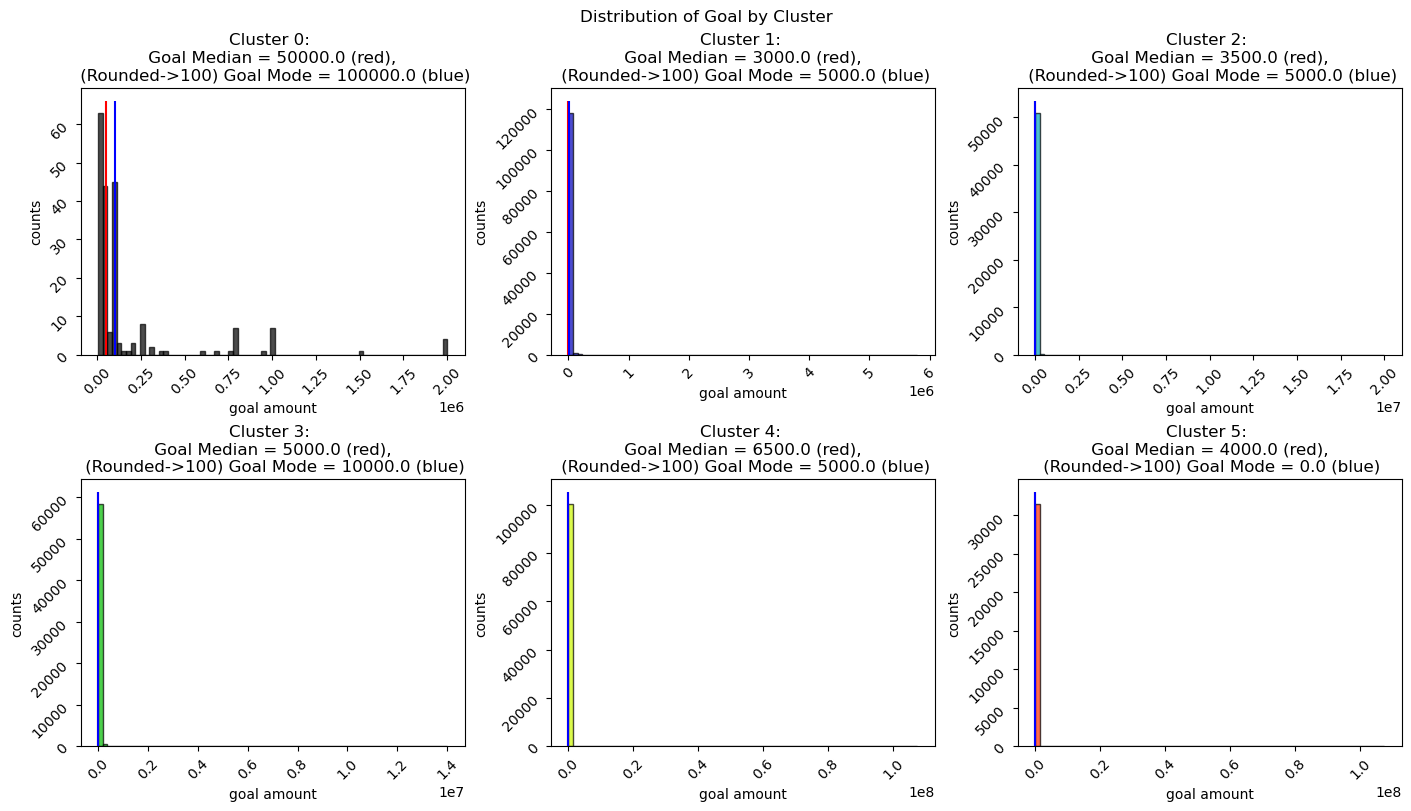

In [92]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of Goal by Cluster")

pledged_x_lims = [1e5, 2e5, 1e5, 2e5, 1e5, 1e5]
pledged_y_lims = [1.25e4, 6e3, 1.5e4, 5e4, 1e4, 5e3]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_analysis.loc[df_analysis['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[:, 'goal_usd'].values
    median = np.median(hist_data);
    mode = custom_mode(custom_round(hist_data, 2));
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}: \n Goal Median = {:.1f} (red), \n (Rounded->100) Goal Mode = {:.1f} (blue)'.format(index, median, mode))
    ax.set_xlabel('goal amount')
    ax.set_ylabel('counts')
    #ax.set_xlim([0, pledged_x_lims[index]])    
    #ax.set_ylim([0, pledged_y_lims[index]])
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)
    ylims = ax.get_ylim();
    ax.vlines(median, ylims[0], ylims[1], colors = 'r')
    ax.vlines(mode, ylims[0], ylims[1], colors = 'b')

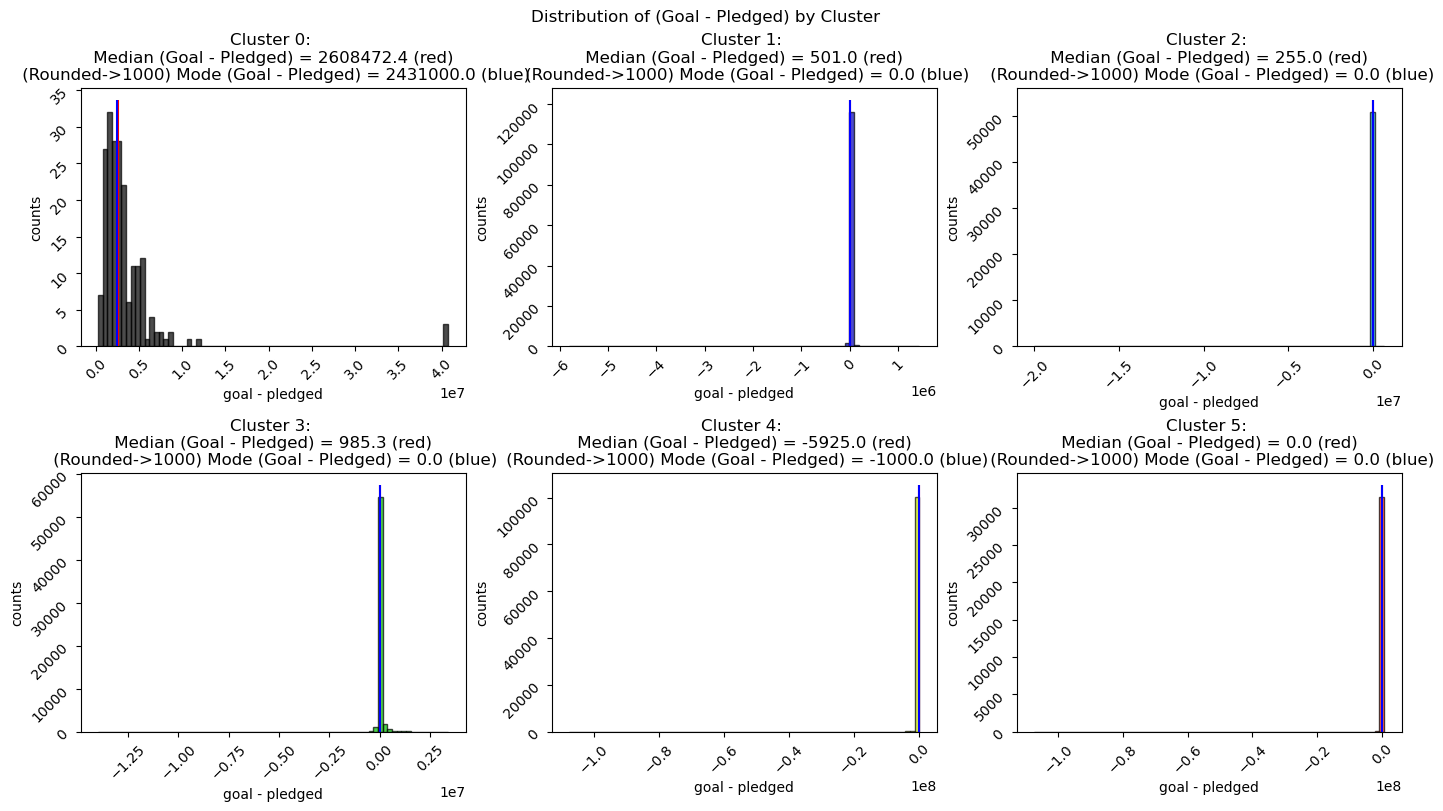

In [93]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of (Goal - Pledged) by Cluster")

difference_absolute_maxima = [5e4, 1e5, 7.5e4, 1e5, 3e4, 2e4]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):  
    df_temp = df_analysis.copy()
    df_temp = df_temp.loc[df_temp['labels_6_clusters'] == index, :]
    df_temp['difference'] = np.nan;
    df_temp.loc[:, 'difference'] = df_temp.apply(lambda x : x['pledged_usd'] - x['goal_usd'], axis = 1)
    #df_temp = df_temp.loc[(df_temp['difference'] >= -difference_absolute_maxima[index]) & (df_temp['difference'] <= difference_absolute_maxima[index]), :]
                      
    hist_data = df_temp['difference'].values
    median = np.median(hist_data);
    mode = custom_mode(custom_round(hist_data, 3));
    
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}: \n Median (Goal - Pledged) = {:.1f} (red) \n (Rounded->1000) Mode (Goal - Pledged) = {:.1f} (blue)'.format(index, median, mode))
    ax.set_xlabel('goal - pledged')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)
    ylims = ax.get_ylim();
    ax.vlines(median, ylims[0], ylims[1], colors = 'r')
    ax.vlines(mode, ylims[0], ylims[1], colors = 'b')

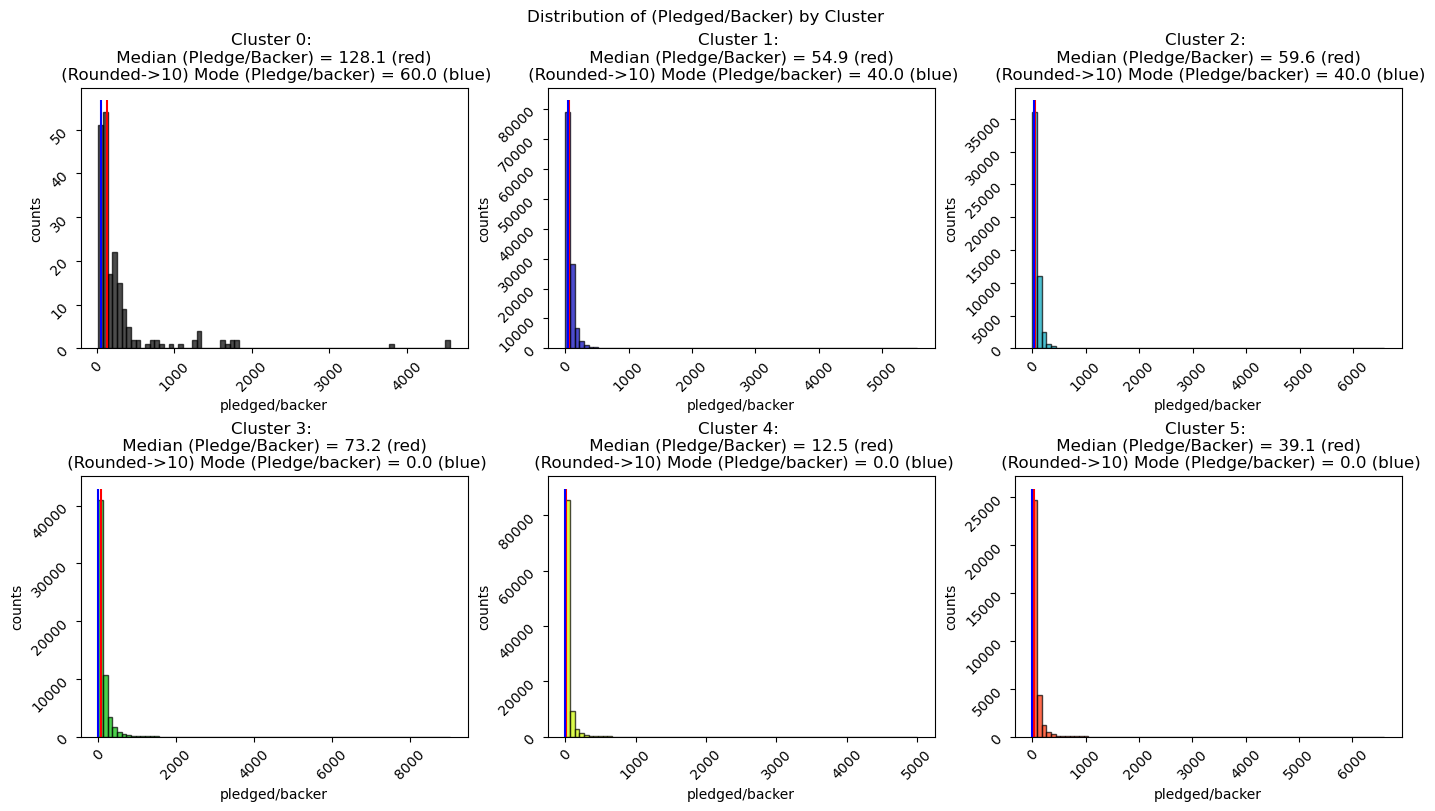

In [94]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of (Pledged/Backer) by Cluster")

difference_absolute_maxima = [6e2, 8e2, 3e2, 2e2, 4e2, 4e2]
for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):  
    df_temp = df_analysis.copy()
    df_temp = df_temp.loc[df_temp['labels_6_clusters'] == index, :]
    df_temp['difference'] = np.nan;
    df_temp.loc[:, 'difference'] = df_temp.apply(lambda x : x['pledged_usd']/(x['backers_count']+1), axis = 1)
    #df_temp = df_temp.loc[(df_temp['difference'] >= -difference_absolute_maxima[index]) & (df_temp['difference'] <= difference_absolute_maxima[index]), :]
                      
    hist_data = df_temp['difference'].values
    median = np.median(hist_data)
    mode = custom_mode(custom_round(hist_data, 1));
        
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}: \n Median (Pledge/Backer) = {:.1f} (red) \n (Rounded->10) Mode (Pledge/backer) = {:.1f} (blue)'.format(index, median, mode))
    ax.set_xlabel('pledged/backer')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)
    ylims = ax.get_ylim();
    ax.vlines(median, ylims[0], ylims[1], colors = 'r')
    ax.vlines(mode, ylims[0], ylims[1], colors = 'b')

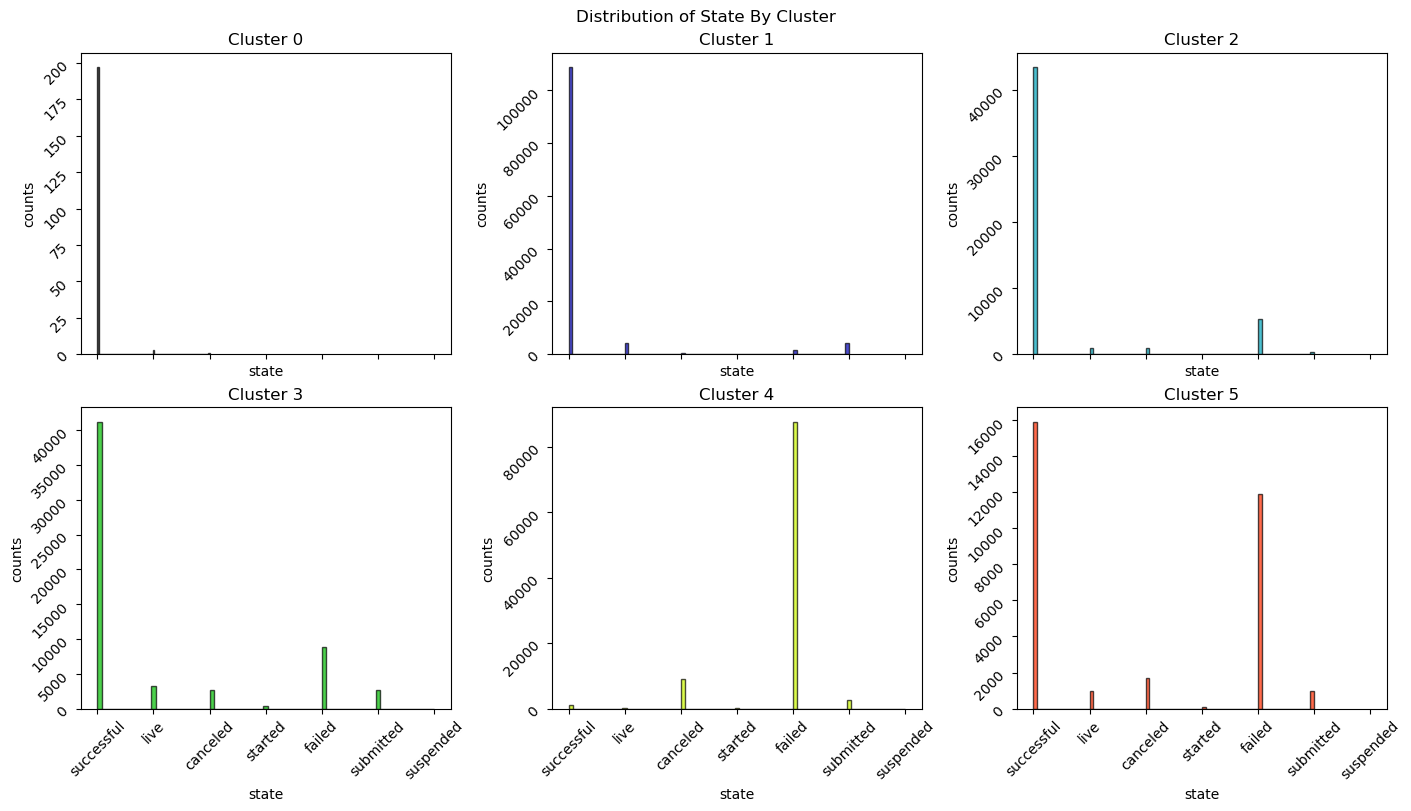

In [95]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, sharex = True, figsize = (14, 8), layout = 'constrained')
fig.suptitle("Distribution of State By Cluster")

for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_analysis.loc[df_analysis['labels_6_clusters'] == index , :]
    hist_data = hist_data.loc[:, 'state'].values
    ax.tick_params(rotation = 45)
    ax.set_title('Cluster {}'.format(index))
    ax.set_xlabel('state')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.hist(hist_data, 75, facecolor = color, edgecolor = 'k', alpha = 0.7)

##### Count all the instances of the categories and plot these counts for each cluster as bar charts.

In [96]:
category_count_prototype = {}
for category in sorted(df_analysis['category'].unique()):
    category_count_prototype.update({category : 0})

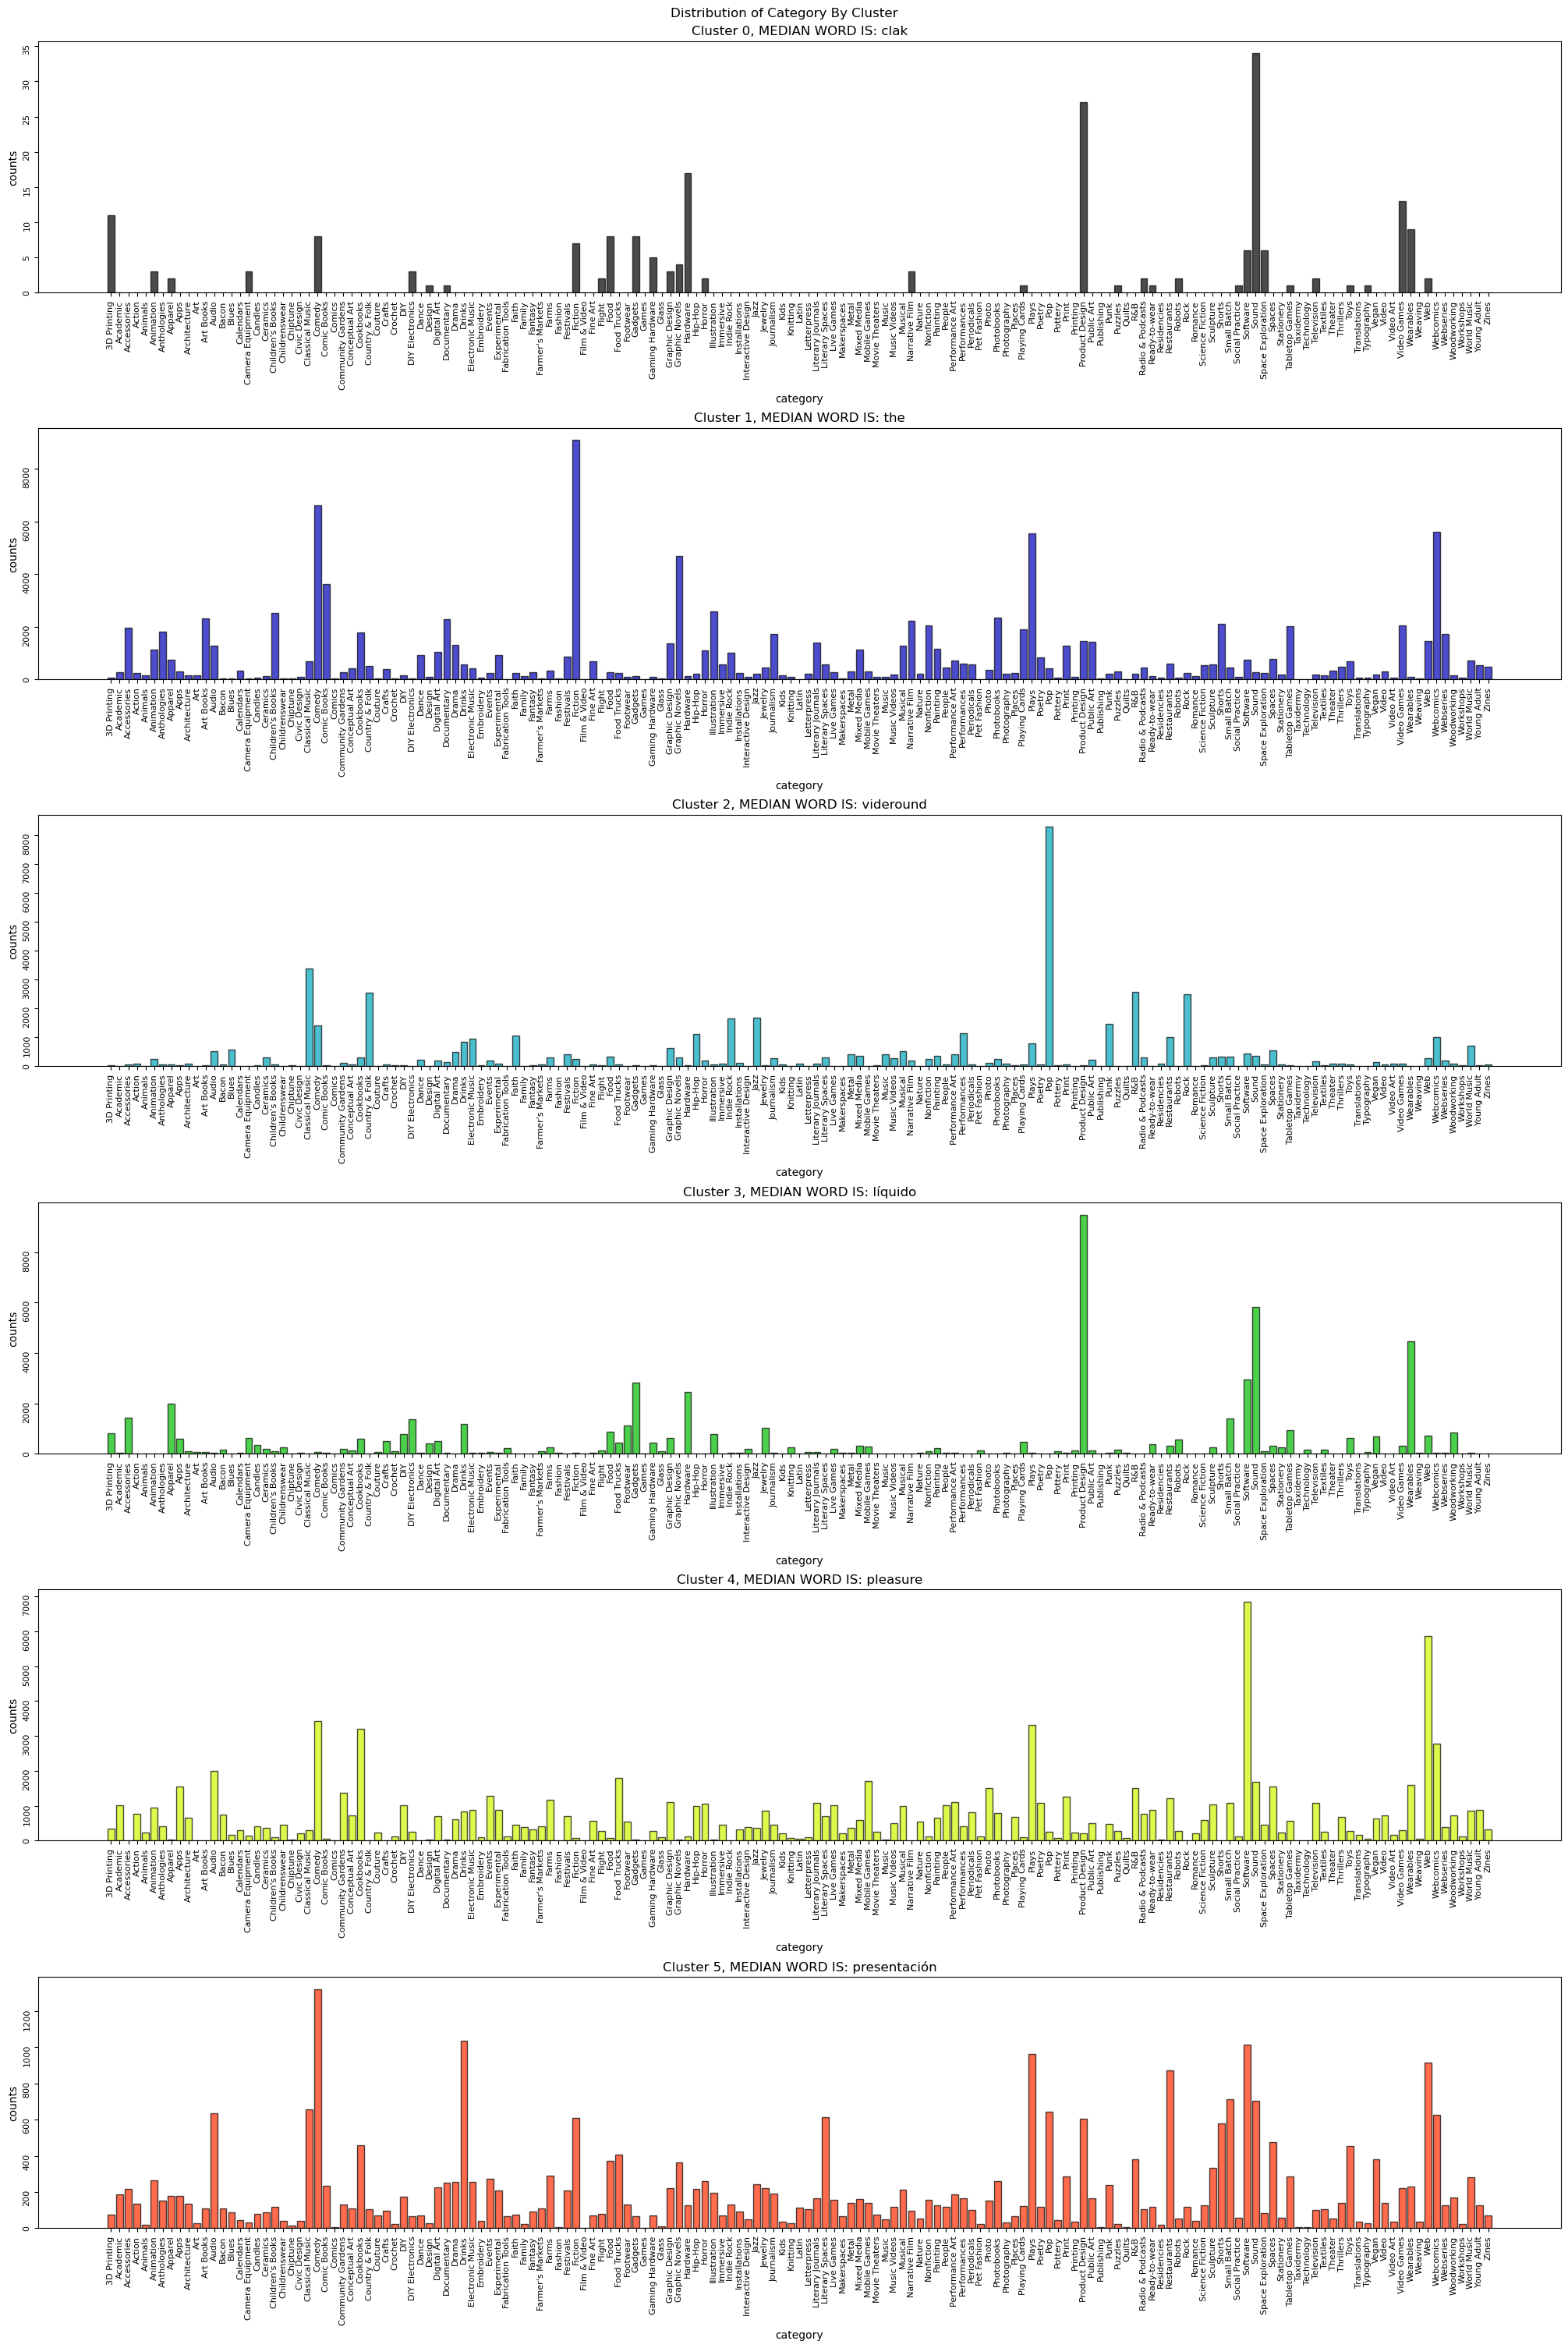

In [97]:
fig, ((ax0), (ax1), (ax2), (ax3), (ax4), (ax5)) = plt.subplots(nrows = 6, ncols = 1, sharex = True, figsize = (20, 30), layout = 'constrained')
fig.suptitle("Distribution of Category By Cluster")

for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    hist_data = df_analysis.loc[df_analysis['labels_6_clusters'] == index , :]
    median_word = hist_data['median_cluster_word'].iloc[0]
    
    hist_data = sorted(hist_data.loc[:, 'category'].values)
    
    category_count = category_count_prototype.copy()
    for element in hist_data:
        category_count[element] += 1;
    
    keys = category_count.keys();
    values = category_count.values()
    
    ax.tick_params(rotation = 90, labelbottom = True, labelsize = 8)
    ax.set_title('Cluster {}, MEDIAN WORD IS: {}'.format(index, median_word))
    ax.set_xlabel('category')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.bar(keys, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')

##### Count the number of median data point word instances and then take the top 20 for each cluster and plot them.

In [98]:
_median_word_frequencies = {}
for word in df_analysis['median_data_point_word'].values:
    _median_word_frequencies.update({word : 0.0})

In [99]:
def count_word_instances(input_array, threshold):
    median_word_frequencies = _median_word_frequencies.copy();
    for word in sorted(input_array):
        median_word_frequencies[word] += 1;
        
    return_dict = {}
    for word in median_word_frequencies:
        if median_word_frequencies[word] >= threshold:
            return_dict.update({word : median_word_frequencies[word]})
     
    return_dict = sorted(return_dict.items(), key = lambda x : x[1], reverse = True)
    
    return return_dict;

In [ ]:
mwf = {}
cutoff_count = [10, 10, 10, 10, 10, 10]
take_first_n = 20
for cluster in sorted(df_analysis['labels_6_clusters'].unique()):
    words_in_cluster = df_analysis.loc[df_analysis['labels_6_clusters'] == cluster, 'median_data_point_word'].values
    sorted_list = count_word_instances(words_in_cluster, cutoff_count[cluster])[0:take_first_n-1]
    mwf.update({cluster : sorted_list});

In [ ]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10), layout = 'constrained')
fig.suptitle("Distribution of Median Word By Cluster")

for index, ax in enumerate((ax0, ax1, ax2, ax3, ax4, ax5)):
    mwf_copy = mwf.copy()
    cluster_dict = dict(mwf[index])
    
    keys = cluster_dict.keys();
    values = cluster_dict.values()
    
    ax.tick_params(rotation = 90, labelbottom = True, labelsize = 10)
    ax.set_title('Cluster {}'.format(index, median_word))
    ax.set_xlabel('median word frequency')
    ax.set_ylabel('counts')
    color = cm.nipy_spectral(float(index/len(backer_x_lims)))
    ax.bar(keys, values, facecolor = color, edgecolor = 'k', alpha = 0.7, align = 'center')

##### Do a raw word frequency tally and then take the top 20 words for each cluster.

In [ ]:
df_cluster = pd.read_csv("./labled_cluster_data_with_6_clusters.csv");
df_cluster.head(1)

In [ ]:
df_sentences = pd.read_csv("./usd_converted_data_with_sentences.csv")

In [ ]:
df_cluster.head(1)

In [ ]:
df_clustered_sentences = pd.merge(df_sentences[['pledged_usd', 'goal_usd', 'backers_count', 'sentences', 'state', 'category']], 
                                  df_cluster[['pledged_usd', 'goal_usd', 'backers_count', 'labels_6_clusters', 'state', 'category']], 
                                  on = ['pledged_usd', 'goal_usd', 'backers_count', 'state', 'category'], how = "inner").drop_duplicates(subset = ['sentences'])

##### Apply simple pre-process to the sentences again.

In [ ]:
df_clustered_sentences_select = df_clustered_sentences[['labels_6_clusters', 'sentences']].copy()

In [ ]:
df_clustered_sentences_select.loc[:, 'processed_sentences'] = df_clustered_sentences['sentences'].apply(lambda x : simple_preprocess(x))

In [ ]:
word_frequency_by_cluster_dict = {}
corpus_by_cluster_dict = {}

for label in df_clustered_sentences_select['labels_6_clusters'].unique():
    word_frequency_by_cluster_dict.update({label : {}})
    corpus_by_cluster_dict.update({label : []})

In [ ]:
for key in corpus_by_cluster_dict:
    for index, row in df_clustered_sentences_select.loc[(df_clustered_sentences_select['labels_6_clusters'] == key), :].iterrows():
        corpus_by_cluster_dict[key] = corpus_by_cluster_dict[key] + row['processed_sentences']

In [ ]:
words_to_ignore = ['the', 'of', 'and', 'to', 'in', 'an', 'with', 'for',
                   'is', 'by', 'that', 'this', 'on', 'about', 'your', 'you', 
                   'from', 'all', 'it', 'into', 'my', 'our', 'up', 'down',
                   'we', 'will', 'our', 'my', 'as', 'are', 'at', 'but', 'off', 'on',
                   'be', 'who', 'have', 'get', 'can', 'want', 'way', 'or', ];

In [ ]:
for key in corpus_by_cluster_dict:
    unique_words_for_cluster = set(corpus_by_cluster_dict[key])
    for word in unique_words_for_cluster:
        if word in words_to_ignore:
            continue;
        else:
            word_frequency_by_cluster_dict[key].update({word : corpus_by_cluster_dict[key].count(word)})
        
    word_frequency_by_cluster_dict[key] = sorted(word_frequency_by_cluster_dict[key].items(), key = lambda x : x[1], reverse = True)

##### Make a data frame to hold the top 20 most frequent words and their frequencies for each cluster

In [ ]:
word_frequency = pd.DataFrame(columns = ["0_words", "0_counts", 
                                         "1_words", "1_counts",
                                         "2_words", "2_counts",
                                         "3_words", "3_counts",
                                         "4_words", "4_counts",
                                         "5_words", "5_counts"],
                              index = list(range(0, 20)))

In [ ]:
for index, key in enumerate(word_frequency_by_cluster_dict):
    word_column_name = str(index) + "_words"
    counts_column_name = str(index) + "_counts"
    
    words, counts = zip(*word_frequency_by_cluster_dict[key][0:20])
    
    word_frequency.loc[:, word_column_name] = words;
    word_frequency.loc[:, counts_column_name] = counts

In [ ]:
word_frequency

##### Plot the word frequencies for each clutser

In [ ]:
fig, ax = plt.subplots(nrows = 6, ncols = 1, figsize = (15, 20), layout = 'constrained');
fig.suptitle("Word Frequencies Across the Six Clusters")

for index in range(6):
    word_column_name = str(index) + "_words"
    counts_column_name = str(index) + "_counts"
    
    words = word_frequency[word_column_name].values
    counts = word_frequency[counts_column_name].values
    
    colors = cm.nipy_spectral(float(index/6));
    ax[index].set_title("Cluster {} Top 20 Word Frequencies".format(index))    
    ax[index].bar(np.array(words), np.array(counts), edgecolor = 'k', facecolor = colors, align = 'center')
